In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['station', 'measurement']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# import inspect from sqlachemy
from sqlalchemy import inspect

# Inspect tables to get all column names
inspector = inspect(engine)

# Get all columns in measurement table
columns_m = inspector.get_columns('measurement')
for c in columns_m:
    print(c['name'], c['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [10]:
# Find the most recent date in the data set.
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23',)

In [11]:
# Store most recent date into variable, then get beginning date using dt.timedelta
last_date = dt.date(2017,8,23)
last_twelve_months = last_date - dt.timedelta(days=365)

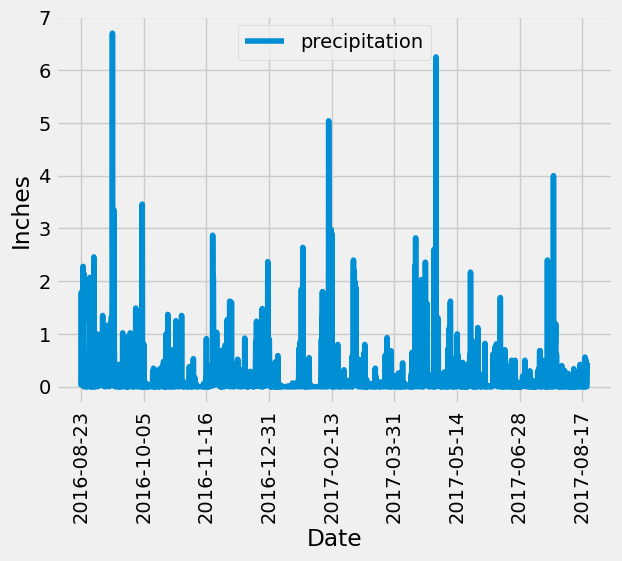

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Perform a query to retrieve the data and precipitation scores

twelve_months_query = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date <= last_date).\
    filter(Measurement.date >= last_twelve_months).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names

df = pd.DataFrame(twelve_months_query, columns=['date','precipitation'])
df = df.sort_values('date') #Sort by date
df = df.dropna(how='any') # Drop NaN values
df.set_index('date', inplace=True) # Set date column as index

# Use Pandas Plotting with Matplotlib to plot the data
df.plot(rot=90)
plt.ylabel('Inches')
plt.xlabel('Date')
plt.show()

In [13]:
# Use Pandas to calculate the summary statistics for the precipitation data
df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [14]:
# Design a query to calculate the total number of stations in the dataset
session.query(Measurement.station).distinct().count()

9

In [15]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# Create list for query. Use func.count() to get count of stations. Assign query list to variable.
sel = [Measurement.station,
       func.count(Measurement.station)]

# List the stations and their counts in descending order.
station_counts = session.query(*sel).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()

station_counts

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [16]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

# Set variable for most active station
most_active_station = station_counts[0][0]

# Create list for query; use func.min,max,avg
sel = [func.min(Measurement.tobs),
       func.max(Measurement.tobs),
       func.avg(Measurement.tobs)]

# Filter to most active station
most_active_temps = session.query(*sel).\
    filter(Measurement.station == most_active_station).\
    group_by(Measurement.station).all()

most_active_temps

[(54.0, 85.0, 71.66378066378067)]

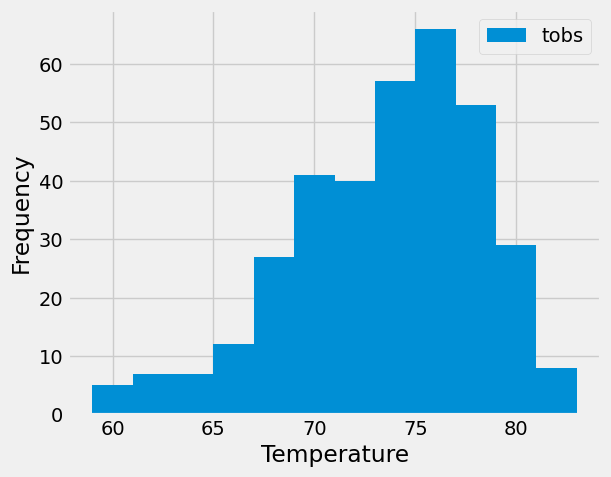

In [17]:
temp = session.query(Measurement.date,Measurement.tobs).\
    filter(Measurement.date <= last_date).\
    filter(Measurement.date >= last_twelve_months).\
    filter(Measurement.station == most_active_station).all()

temp_df = pd.DataFrame(temp, columns=['date','tobs'])

temp_df.hist(column='tobs',bins=12,legend=True, figsize=(6.125,5))
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.title('')
plt.show()

# Close Session

In [18]:
# Close Session
session.close()